In [1]:
%matplotlib widget

In [2]:
import os
from glob import glob
from datetime import datetime

from tqdm.notebook import tqdm

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from astropy.io import fits
from astropy.wcs import wcs
import ipywidgets as widgets
from IPython.display import display, Image, clear_output

from vasca.resource_manager import ResourceManager
import vasca.utils as vutils

In [3]:
# Settings

# Input/output directories
with ResourceManager() as rm:
    root_data_dir = rm.get_path("gal_ds_fields", "lustre")
    out_dir = (os.sep).join(
        rm.get_path("gal_ds_visits_list", "lustre").split(os.sep)[:-1]
    )

In [4]:
def display_fits_img(path, hdu_idx=1):
    """
    Generic plot function to display a sky map stored as FITS files.
    """
    
    file_name = path.split(os.sep)[-1]
    if file_name.endswith("gz"):
        file_name.rstrip(".fits.gz")
    else:
        file_name.rstrip(".fits")
        
    plot_name = file_name
    with fits.open(path) as hdul:
        img = hdul[hdu_idx].data
        img_wcs = wcs.WCS(hdul[hdu_idx].header)
    
    fig, ax = vutils.nb_fig(
        num=plot_name,
        figsize=(8,8),
        layout="tight",
        subplot_kw={'projection': img_wcs}
    )

    # image
    ax.imshow(img, norm=LogNorm(), cmap="gray_r", interpolation="none")
    
    # modify grid
    ax.coords.grid(True, color='gray', lw=0.75, ls='-', zorder=0)

    # set axis labels
    ra = ax.coords["ra"]
    dec = ax.coords["dec"]
    ra.set_major_formatter("d.dd")
    dec.set_major_formatter("d.dd")

    label_fontsize = 10
    ax.set_xlabel("Ra", fontsize=label_fontsize)
    ax.set_ylabel("Dec", fontsize=label_fontsize)
    ax.xaxis.set_tick_params(labelsize=label_fontsize)
    ax.yaxis.set_tick_params(labelsize=label_fontsize)
    ax.tick_params(axis="x", labelsize=label_fontsize, direction="in", bottom=True, top=False)
    ax.tick_params(axis="y", labelsize=label_fontsize, direction="in", left=True, right=False)
    plt.show()


In [5]:
def combine_qreports(good_images, strange_images, bad_images, field_name, report_name="img_qual", out_dir="."):
    # Export result
    quals = list()
    for qlist, q in zip([good_images, strange_images, bad_images], ["good", "strange", "bad"]):
        df = pd.DataFrame(
            {
                "name": [path.split(os.sep)[-1] for path in qlist],
                "quality": [q]*len(qlist),
                "path": qlist
            }
        )
        if len(df) > 0:
            quals.append(df)
    df_quals = pd.concat(quals)
    df_quals.sort_values("path", inplace=True)
    df_quals.reset_index(drop=True, inplace=True)

    out = f"{out_dir}/img_quality/{field_name}"
    os.makedirs(out, exist_ok=True)
    df_quals.to_csv(
        f"{out}/{report_name}_"
        f"{datetime.today().strftime('%Y-%m-%d_%H-%M-%S')}.csv"
    )
    
    return df_quals

In [6]:
# Display image function
def display_image(image_path, **dsply_kwargs):
    with image_output:
        clear_output(wait=True)
        plt.close(plt.gcf())
        display_fits_img(image_path, **dsply_kwargs)

# Image inspection function
def inspect_images(image_paths, img_quality, field_name=None, report_name=None, out_dir=None, **dsply_kwargs):
    index = 0
    total_images = len(image_paths)

    def process_image(button):
        nonlocal index

        quality = button.description
        image_path = image_paths[index]
        img_name = image_path.split(os.sep)[-1]
        if img_name.endswith("gz"):
            img_name.rstrip(".fits.gz")
        else:
            img_name.rstrip(".fits")
        
        if quality == 'Good':
            print(f"Image {img_name} is good!")
            img_quality["good_images"].append(image_path)
        elif quality == 'Strange':
            print(f"Image {img_name} is strange!")
            img_quality["strange_images"].append(image_path)
        elif quality == 'Bad':
            print(f"Image {img_name} is bad!")
            img_quality["bad_images"].append(image_path)

        index += 1
        update_progress_label()
        
        if index >= len(image_paths):
            print("Inspection completed.")
            if report_name is not None and out_dir is not None and field_name is not None:
                print("Exporting results.")
                combine_qreports(
                    img_quality["good_images"],
                    img_quality["strange_images"],
                    img_quality["bad_images"],
                    field_name,
                    report_name,
                    out_dir
                )
        else:
            reset_buttons()
            display_image(image_paths[index], **dsply_kwargs)
    
    def reset_buttons():
        for button in quality_buttons:
            button.value = False
            
    def update_progress_label():
        progress_label.value = f"Progress: {index}/{total_images} images checked"

    quality_buttons = [
        widgets.Button(description='Good', button_style='success'),
        widgets.Button(description='Strange', button_style='warning'),
        widgets.Button(description='Bad', button_style='danger')
    ]

    buttons_box = widgets.HBox(quality_buttons)
    display(buttons_box)
    display(progress_label)
    display(image_output)

    for button in quality_buttons:
        button.on_click(lambda btn, button=button: process_image(button))

    update_progress_label()
    display_image(image_paths[index], **dsply_kwargs)

In [7]:
def check_ds_field(field_name, report_name="img_qual", out_dir=".", force=False, **dsply_kwargs):
    """
    Visually inspect the qulity of a GALEX drift scan field.
    """
    
    # Gets file paths to the images
    with ResourceManager() as rm:
        root_data_dir = rm.get_path("gal_ds_fields", "lustre")
    
    scan_name = field_name.split("_sv")[0]
    field_path = f"{root_data_dir}/{scan_name}/{field_name}"
    
    img_paths = glob(f"{field_path}/*/*-nd-cnt.fits.gz")
    
    # Qualtiy check
    
    # List to store information about image quality
    img_quality = {
        "good_images": list(),
        "strange_images": list(),
        "bad_images": list(),
    }

    # Output widget for displaying images progress indicator
    global image_output
    image_output = widgets.Output()
    global progress_label
    progress_label = widgets.Label()

    if force or not os.path.isdir(f"{out_dir}/img_quality/{field_name}"):
        # Start inspection
            inspect_images(
            sorted(img_paths),
            img_quality=img_quality,
            field_name=field_name,
            report_name=report_name,
            out_dir=out_dir,
            **dsply_kwargs
        )
    else:
        print("Quality check already done.")

In [8]:
# Gets fields 
field_paths = sorted(glob(f"{root_data_dir}/*/*"))
field_names = [path.split(os.sep)[-1] for path in field_paths]
field_names

['29200-KEPLER_SCAN_001_sv01',
 '29200-KEPLER_SCAN_001_sv02',
 '29200-KEPLER_SCAN_001_sv03',
 '29200-KEPLER_SCAN_001_sv04',
 '29200-KEPLER_SCAN_001_sv05',
 '29200-KEPLER_SCAN_001_sv06',
 '29200-KEPLER_SCAN_001_sv07',
 '29200-KEPLER_SCAN_001_sv08',
 '29200-KEPLER_SCAN_001_sv09',
 '29205-KEPLER_SCAN_006_sv01',
 '29205-KEPLER_SCAN_006_sv02',
 '29205-KEPLER_SCAN_006_sv03',
 '29205-KEPLER_SCAN_006_sv04',
 '29205-KEPLER_SCAN_006_sv05',
 '29205-KEPLER_SCAN_006_sv06',
 '29205-KEPLER_SCAN_006_sv07',
 '29205-KEPLER_SCAN_006_sv08',
 '29205-KEPLER_SCAN_006_sv09',
 '29205-KEPLER_SCAN_006_sv10',
 '29205-KEPLER_SCAN_006_sv11',
 '29205-KEPLER_SCAN_006_sv12',
 '29205-KEPLER_SCAN_006_sv13',
 '29205-KEPLER_SCAN_006_sv14',
 '29206-KEPLER_SCAN_007_sv01',
 '29206-KEPLER_SCAN_007_sv02',
 '29206-KEPLER_SCAN_007_sv03',
 '29206-KEPLER_SCAN_007_sv04',
 '29206-KEPLER_SCAN_007_sv05',
 '29206-KEPLER_SCAN_007_sv06',
 '29206-KEPLER_SCAN_007_sv07',
 '29206-KEPLER_SCAN_007_sv08',
 '29206-KEPLER_SCAN_007_sv09',
 '29206-

In [23]:
check_ds_field('29207-KEPLER_SCAN_008_sv14', force=False, hdu_idx=0)

Label(value='')

Output()

In [29]:
plt.close("all")

In [30]:
# Combine quality reports
reports = list()
for report_path in glob("./img_quality/*/*.csv"):
    df = pd.read_csv(report_path, index_col=0)
    reports.append(df)
df_reports = pd.concat(reports)
df_reports.insert(2, "vis_name", [path.split(os.sep)[-2] for path in df_reports.path])

# Export
df_reports.to_csv(f"{out_dir}/GALEX_DS_GCK_visits_img_quality.csv")
df_reports.to_html(f"{out_dir}/GALEX_DS_GCK_visits_img_quality.html")

In [31]:
len(np.unique(df_reports.path))

1359

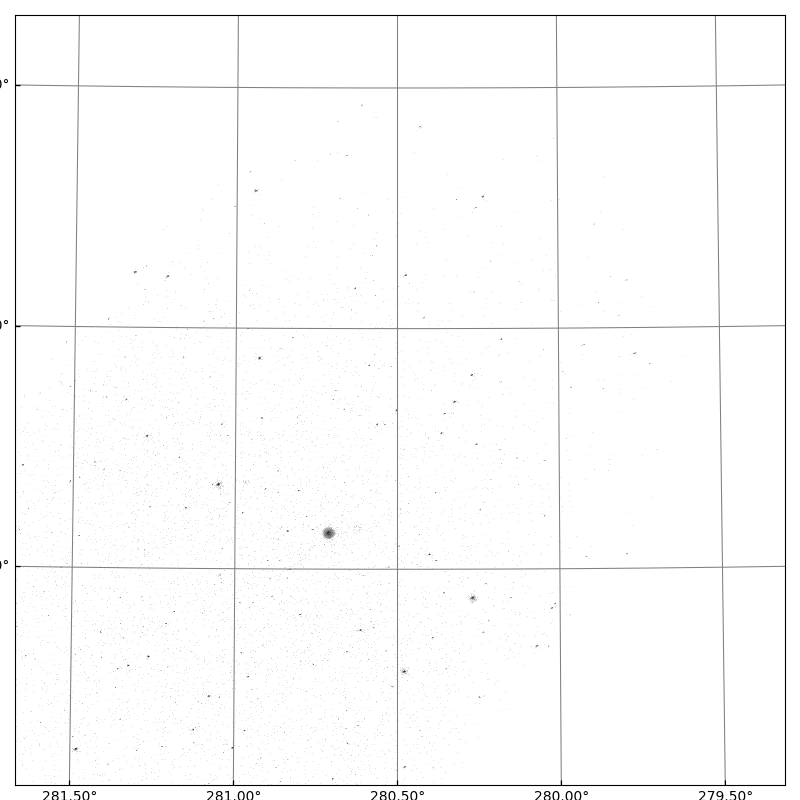

In [12]:
plt.close("all")
display_fits_img("/Users/julianschliwinski/GALEX_DS/GALEX_DS_GCK_fields/29203-KEPLER_SCAN_004/29203-KEPLER_SCAN_004_sv01/29203-KEPLER_SCAN_004_sv01_0020-img/KEPLER_SCAN_004_0020_sv01-nd-cnt.fits.gz", hdu_idx=0)

In [18]:
# List to store information about image quality
img_quality = {
    "good_images": list(),
    "strange_images": list(),
    "bad_images": list(),
}

# Output widget for displaying images progress indicator
image_output = widgets.Output()
progress_label = widgets.Label()

# Start inspection
inspect_images(sorted(glob(f"{root_data_dir}/29200-KEPLER_SCAN_001/29200-KEPLER_SCAN_001_sv02/*/*-nd-cnt.fits.gz")),img_quality , hdu_idx=0)

Label(value='')

Output()